In [69]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn as nn

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [71]:
dataset = load_dataset(path=r"C:\Users\mlfav\lib\shlee\color_model\ColorModel", split="train")
dataset.set_format(type="torch", columns=["input_data", "output_color"], dtype=torch.float32)
dataset.shape

c:\Users\mlfav\anaconda3\envs\kjk_py39\lib\site-packages\datasets\load.py:922: FutureWarning: The repository for ColorModel contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at C:\Users\mlfav\lib\shlee\color_model\ColorModel\ColorModel.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


(57243, 16)

In [72]:
total_size = len(dataset)
train_size = int(total_size * 0.6)
valid_size = total_size - train_size
train_data, valid_data = random_split(dataset, [train_size, valid_size])
train_size, valid_size

(34345, 22898)

In [73]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=True, num_workers=2, drop_last=True)

In [74]:
data = train_loader.__iter__().__next__()
input_size = data['input_data'].shape[1]
input_size

119

In [75]:
output_size = data['output_color'].shape
output_size

torch.Size([4, 12])

In [76]:
alpha = 0.01
epochs = 100

In [77]:
class LassoModel(nn.Module):
    def __init__(self, input_size):
        super(LassoModel, self).__init__()
        self.normalize = nn.LayerNorm((input_size,))
        self.hidden1 = nn.Linear(input_size, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.linear = nn.Linear(32, 12)

    def forward(self, x):
        x = self.normalize(x)
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.nn.functional.relu(self.hidden2(x))
        x = self.linear(x)
        return x

In [78]:
def lasso_loss(model, h, y):
    mse_loss = nn.functional.mse_loss(h, y)
    
    l1_regularization = alpha * torch.sum(torch.abs(model.linear.weight))
    
    total_loss = mse_loss + l1_regularization
    
    return total_loss

In [79]:
epochs = 100
learning_rate = 0.0002

In [80]:
model = LassoModel(input_size).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_func = torch.nn.MSELoss()

In [81]:
def train_epoch(train_loader):
    train_loss = []
    for data in train_loader:
        x = data['input_data'].to(device)
        y = data['output_color'].to(device)

        output = model.forward(x)

        loss = lasso_loss(model, output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())

    return np.array(train_loss).mean()

def valid_epoch(valid_loader):
    valid_loss = []
    for data in valid_loader:
        x = data['input_data'].to(device)
        y = data['output_color'].to(device)

        output = model.forward(x)
        loss = lasso_loss(model, output, y)

        valid_loss.append(loss.cpu().detach().numpy())
    return np.array(valid_loss).mean()

In [82]:
train_loss = []
valid_loss = []

for epoch in range(epochs):
    
    t_loss = train_epoch(train_loader)
    v_loss = valid_epoch(valid_loader)
    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    print(f"epoch: {epoch} | train: {round(t_loss, 3)}, valid: {round(v_loss, 3)}")

epoch: 0 | train: 3019.913330078125, valid: 2710.207275390625
epoch: 1 | train: 2723.782470703125, valid: 2705.209228515625
epoch: 2 | train: 2667.96533203125, valid: 2606.157470703125
epoch: 3 | train: 2636.092529296875, valid: 2656.312744140625
epoch: 4 | train: 2613.82177734375, valid: 2593.611328125
epoch: 5 | train: 2595.88525390625, valid: 2536.5908203125
epoch: 6 | train: 2591.074951171875, valid: 2714.6630859375
epoch: 7 | train: 2573.798095703125, valid: 2709.92236328125
epoch: 8 | train: 2556.40625, valid: 2544.03466796875
epoch: 9 | train: 2543.769775390625, valid: 2499.393798828125
epoch: 10 | train: 2532.33056640625, valid: 2543.683349609375
epoch: 11 | train: 2524.134521484375, valid: 2571.804443359375
epoch: 12 | train: 2517.349853515625, valid: 2557.767578125
epoch: 13 | train: 2508.956787109375, valid: 2583.6455078125
epoch: 14 | train: 2504.375, valid: 2509.0234375
epoch: 15 | train: 2500.064697265625, valid: 2546.17919921875
epoch: 16 | train: 2493.68994140625, valid

KeyboardInterrupt: 

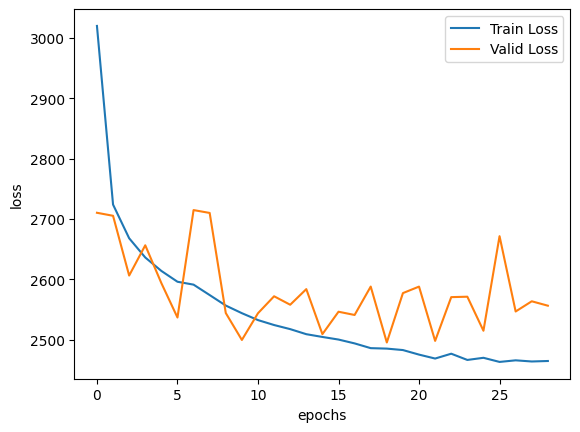

In [83]:
plt.plot([float(loss) for loss in train_loss], label='Train Loss')
plt.plot([float(loss) for loss in valid_loss], label='Valid Loss')
# plt.plot([float(lr[0]) for lr in learning_rates], label='Learning Rate')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [114]:
with torch.no_grad():
    data = valid_loader.__iter__().__next__()
    x = data['input_data'].to(device)
    y = data['output_color']
    output = model.forward(x)

In [115]:
print(x[:,:12].shape) # input data
print(y.shape)        # label data
print(output.shape)   # output data

torch.Size([4, 12])
torch.Size([4, 12])
torch.Size([4, 12])


In [116]:
import colorsys

def hsv_to_rgb(hsv_array):
    rgb_array = np.zeros_like(hsv_array)
    for i in range(hsv_array.shape[0]):
        h, s, v = hsv_array[i] / np.array([360, 100, 100])
        r, g, b = colorsys.hsv_to_rgb(h.item(), s.item(), v.item())
        rgb_array[i] = np.array([int(r*255), int(g*255), int(b*255)])

    return rgb_array

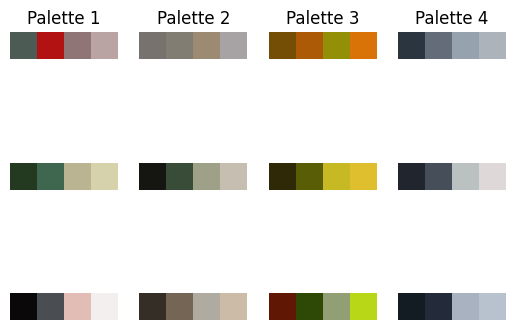

In [117]:
batch_size = 4
for b in range(batch_size):
    rgb = x[:,:12][b].type(torch.int).cpu().detach().numpy().reshape((4,3)) # input colors
    label = y[b].type(torch.int).numpy().reshape((4,3)) # label color
    label = hsv_to_rgb(label).reshape((4,3))
    val = output[b].type(torch.int).cpu().detach().numpy().reshape((4,3)) # return color
    val = hsv_to_rgb(val).reshape((4,3))
    
    plt.subplot(3, batch_size, 1+b)
    plt.imshow([rgb])
    plt.axis(False)
    plt.title(f'Palette {b+1}')
    plt.subplot(3, batch_size, b+1+batch_size)
    plt.imshow([val])
    plt.axis(False)

    plt.subplot(3, batch_size, b+1+batch_size*2)
    plt.imshow([label])
    plt.axis(False)


In [118]:
PATH = './Model/model.pt'
torch.save(model.state_dict(), PATH)